# Simulating Inverse Compton Scattering

In [1]:
import RF_Track as RFT
import time
import numpy as np
import matplotlib.pyplot as plt

### Define beam-laser IP parameters

In [2]:
L_IP = 0.0 # m, length of the IP region
IP_beta = 0.1 # m, beta star
IP_Lstar = L_IP/2 # m
X_angle = 2 # deg, crossing angle

### Define the electron beam parameters

In [3]:
Pref = 50 # MeV/c
Pspread = 3 # permille, momentum spread
sigma_t = 5 * RFT.ps # mm/c
Q_pC = 1000 # pC, bunch charge

In [4]:
def sind(x):
    return np.sin(x * np.pi / 180.0)

def cosd(x):
    return np.cos(x * np.pi / 180.0)

In [5]:
[ sind(180-X_angle), 0, cosd(180-X_angle) ]

[0.0348994967025007, 0, -0.9993908270190959]

### Define the laser beam

In [6]:
LB = RFT.LaserBeam() # Fabry-Pérot resonator
LB.pulse_energy = 28 # mJ, laser pulse energy
LB.pulse_length = 5 # ps, laser pulse length
LB.wavelength = 1030 # nm, laser wavelength
LB.set_direction ( sind(180-X_angle), 0, cosd(180-X_angle)) # 2 degrees crossing angle
LB.length = L_IP;
LB.set_position(IP_Lstar) # m
LB.R = 0.035 # mm, laser rms radius at waist, Gaussian profile
LB.M2 = 1 #
LB.min_number_of_gammas_per_slice = 8
LB.set_nsteps(15)

### Define a lattice

In [7]:
L = RFT.Lattice()
L.append (LB);

### Define the electron bunch

In [8]:
Twiss = RFT.Bunch6d_twiss()
Twiss.emitt_x = 5 # mm.mrad, normalized emittances
Twiss.emitt_y = 5 # mm.mrad
Twiss.beta_x = IP_beta + IP_Lstar**2 / IP_beta # m
Twiss.beta_y = IP_beta + IP_Lstar**2 / IP_beta # m
Twiss.alpha_x = IP_Lstar / IP_beta # converging beam
Twiss.alpha_y = IP_Lstar / IP_beta #
Twiss.sigma_t = sigma_t # mm/c
Twiss.sigma_pt = Pspread # permille

B0 = RFT.Bunch6d(RFT.electronmass, Q_pC*RFT.pC, -1, Pref, Twiss, 10000)

### Perform tracking

In [9]:
start_time = time.time()
B1 = L.track(B0)
end_time = time.time()
print(f"Elapsed time is {end_time - start_time:.2f} seconds")

Elapsed time is 2.58 seconds


### Postprocessing
Separate photons frlm electrons

In [10]:
M1 = B1.get_phase_space('%x %xp %y %yp %t %Pc %m %N %Vz')
M1_w = M1[:, 6] == 0.0  # Check if column 7 (index 6) is 0.0 (photons)

P1 = M1[M1_w]  # Select rows where m == 0.0 (photons)
E1 = M1[~M1_w]  # Select rows where m != 0.0 (electrons)

In [11]:
# %% Total number of gammas produced
Nw_RFT = np.sum(P1[:, 7])  # Column 8 in Octave corresponds to index 7 in Python

# %% Analytic estimate based on the geometric luminosity

# Number of electrons in the bunch
N_e = Q_pC * RFT.pC

# Number of photons in a laser pulse
Nw = LB.pulse_energy * LB.wavelength * 5034116567542.7  # Conversion factor for mJ/(h * c / nm)

# Electron beam size at the interaction point (IP)
sigma_x = np.sqrt(IP_beta * Twiss.emitt_x * RFT.electronmass / Pref)  # mm
sigma_y = np.sqrt(IP_beta * Twiss.emitt_y * RFT.electronmass / Pref)  # mm

# Beam length at the IP
sigma_Z = np.hypot(LB.pulse_length * RFT.ps, sigma_t) * 1e3  # um

# Effective beam sizes accounting for angles and geometry
sigma_X = np.hypot(
    np.hypot(LB.R * 1e3, sigma_x * 1e3) * cosd(X_angle / 2),
    sigma_Z * sind(X_angle / 2),
)  # um

sigma_Y = np.hypot(LB.R * 1e3, sigma_y * 1e3)  # um

# Thomson cross-section
cs_T = 66  # fm^2

# Geometric luminosity-based photon count
Nw_geom = (
    cosd(X_angle / 2)
    * N_e
    * Nw
    / (2 * np.pi * (sigma_X * 1e9) * (sigma_Y * 1e9))  # Convert um to nm
    * cs_T
)

# Print the ratio
print(f'Nw_RFT / Nw_geom = {Nw_RFT / Nw_geom:.6g}')

Nw_RFT / Nw_geom = 1.00442


### Plots

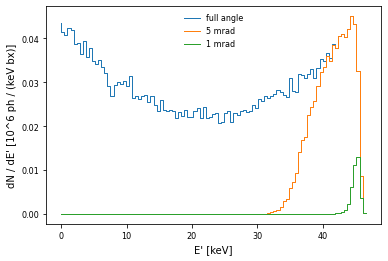

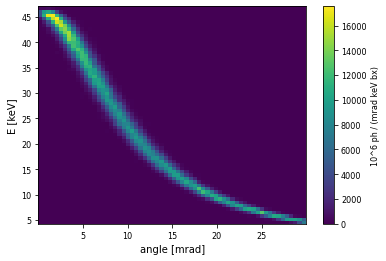

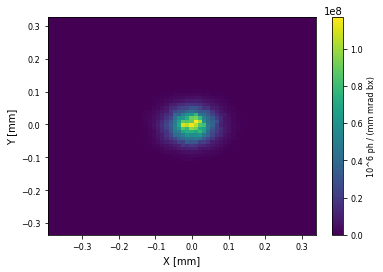

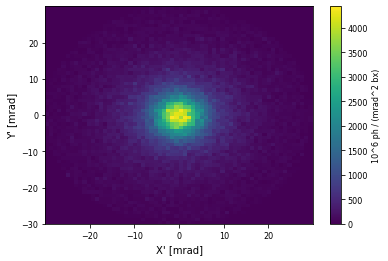

In [12]:
# %% Figure 1
plt.figure()

angle = np.arccos(P1[:,8]) * 1e3  # mrad

# Full angle
H, edges = np.histogram(P1[:, 5] * 1e3, bins=100, weights=P1[:, 7])
bin_width = edges[1] - edges[0]
H = H / bin_width  # Normalize by bin width
plt.step(edges[:-1], H / 1e6, label='full angle', linewidth=1)

# Angle < 5 mrad
mask_5mrad = angle < 5
H, edges = np.histogram(P1[mask_5mrad, 5] * 1e3, bins=edges, weights=P1[mask_5mrad, 7])
H = H / bin_width
plt.step(edges[:-1], H / 1e6, label='5 mrad', linewidth=1)

# Angle < 1 mrad
mask_1mrad = angle < 1
H, edges = np.histogram(P1[mask_1mrad, 5] * 1e3, bins=edges, weights=P1[mask_1mrad, 7])
H = H / bin_width
plt.step(edges[:-1], H / 1e6, label='1 mrad', linewidth=1)

plt.xlabel("E' [keV]")
plt.ylabel("dN / dE' [10^6 ph / (keV bx)]")
plt.legend(loc='best', fontsize=8, frameon=False)
plt.gca().tick_params(labelsize=8)

# Cut large-angle photons
mask = angle <= 30
P1 = P1[mask]
angle = angle[mask]

# %% Figure 2
plt.figure()
H, xedges, yedges = np.histogram2d(
    angle, P1[:, 5] * 1e3, bins=[64, 64], weights=P1[:, 7]
)
bin_area = (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
H = H / bin_area

plt.pcolor(xedges, yedges, H.T / (Nw_RFT / 1e6), shading='auto', cmap='viridis')
plt.xlabel('angle [mrad]')
plt.ylabel('E [keV]')
cb = plt.colorbar()
cb.set_label('10^6 ph / (mrad keV bx)', fontsize=8)
cb.ax.tick_params(labelsize=8)
plt.gca().tick_params(labelsize=8)

# %% Figure 3
plt.figure()
H, xedges, yedges = np.histogram2d(
    P1[:, 0], P1[:, 2], bins=[64, 64], weights=P1[:, 7]
)
bin_area = (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
H = H / bin_area

plt.pcolor(xedges, yedges, H.T / (Nw_RFT / 1e6), shading='auto', cmap='viridis')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
cb = plt.colorbar()
cb.set_label('10^6 ph / (mm mrad bx)', fontsize=8)
cb.ax.tick_params(labelsize=8)
plt.gca().tick_params(labelsize=8)

# %% Figure 4
plt.figure()
H, xedges, yedges = np.histogram2d(
    P1[:, 1], P1[:, 3], bins=[64, 64], weights=P1[:, 7]
)
bin_area = (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
H = H / bin_area

plt.pcolor(xedges, yedges, H.T / (Nw_RFT / 1e6), shading='auto', cmap='viridis')
plt.xlabel("X' [mrad]")
plt.ylabel("Y' [mrad]")
cb = plt.colorbar()
cb.set_label('10^6 ph / (mrad^2 bx)', fontsize=8)
cb.ax.tick_params(labelsize=8)
plt.gca().tick_params(labelsize=8)

plt.show()

### Scan of beta star
Depending on the electron beam and on the laser properties, the optimal $\beta^\star$ (beta function at the IP) might not be the smallest possible. A beta scan will show this.

In [13]:
# Constants
X_angle = 2  # degrees, crossing angle
IP_beta_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]  # m, beta star
Nw = []

# Loop over IP_beta values
for IP_beta in IP_beta_values:
    # Define Twiss parameters
    Twiss = RFT.Bunch6d_twiss()
    Twiss.emitt_x = 5  # mm.mrad, normalized emittance
    Twiss.emitt_y = 5  # mm.mrad
    Twiss.beta_x = IP_beta + IP_Lstar**2 / IP_beta  # m
    Twiss.beta_y = IP_beta + IP_Lstar**2 / IP_beta  # m
    Twiss.alpha_x = IP_Lstar / IP_beta  # converging beam
    Twiss.alpha_y = IP_Lstar / IP_beta
    Twiss.sigma_t = sigma_t  # mm/c
    Twiss.sigma_pt = Pspread  # permille

    # Create the bunch
    B0 = RFT.Bunch6d(RFT.electronmass, Q_pC * RFT.pC, -1, Pref, Twiss, 10000)

    # Define the laser beam
    LB = RFT.LaserBeam()
    LB.pulse_energy = 100  # mJ, laser pulse energy
    LB.pulse_length = 0.5  # ps, laser pulse length
    LB.wavelength = 1030  # nm, laser wavelength
    LB.set_direction(np.sin(np.radians(180 - X_angle)), 0, np.cos(np.radians(180 - X_angle)))
    LB.length = L_IP
    LB.set_position(IP_Lstar)  # m
    LB.R = B0.get_info().sigma_x  # mm, laser rms radius at waist, Gaussian profile
    LB.M2 = 1.1
    LB.min_number_of_gammas_per_slice = 8
    LB.set_nsteps(100)

    # Define the lattice
    L = RFT.Lattice()
    L.append(LB)

    # Track the bunch
    start_time = time.time()
    B1 = L.track(B0)
    end_time = time.time()
    print(f"Tracking time: {end_time - start_time:.2f} seconds")

    # Separate photons from electrons
    M1 = B1.get_phase_space('%x %xp %y %yp %t %Pc %m %N %Vz')
    M1_w = M1[:, 6] == 0.0  # Pick the photons
    E1 = M1[~M1_w]  # Electrons
    P1 = M1[M1_w]  # Photons

    angle = np.arccos(P1[:, 8]) * 1e3  # mrad

    # Photon counts within angle limits
    Nw_RFT_1mrad = np.sum(P1[angle < 1, 7])
    Nw_RFT_5mrad = np.sum(P1[angle < 5, 7])

    print(f'Nw_RFT_1mrad = {Nw_RFT_1mrad}')
    print(f'Nw_RFT_5mrad = {Nw_RFT_5mrad}\n')
    
    # Append results
    Nw.append([IP_beta, Nw_RFT_1mrad, Nw_RFT_5mrad])

# Convert results to a NumPy array for further processing
Nw = np.array(Nw)

Tracking time: 3.52 seconds
Nw_RFT_1mrad = 388228.1948202759
Nw_RFT_5mrad = 9218663.1789055

Tracking time: 3.69 seconds
Nw_RFT_1mrad = 374226.90448763873
Nw_RFT_5mrad = 7625054.767784062

Tracking time: 3.72 seconds
Nw_RFT_1mrad = 282775.19196467346
Nw_RFT_5mrad = 5277141.13588198

Tracking time: 3.20 seconds
Nw_RFT_1mrad = 80614.88706702237
Nw_RFT_5mrad = 1454261.157024521

Tracking time: 3.01 seconds
Nw_RFT_1mrad = 44128.24555905117
Nw_RFT_5mrad = 775094.3380538444

Tracking time: 3.23 seconds
Nw_RFT_1mrad = 8902.772632806935
Nw_RFT_5mrad = 159034.07635630455



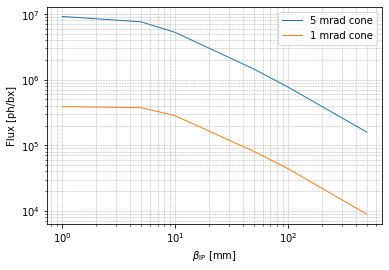

In [14]:
plt.figure()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Plot the data
plt.loglog(Nw[:, 0] * 1e3, Nw[:, 2], label="5 mrad cone", linewidth=1)
plt.loglog(Nw[:, 0] * 1e3, Nw[:, 1], label="1 mrad cone", linewidth=1)

# Add labels and legend
plt.xlabel(r"$\beta_\mathrm{IP}$ [mm]", fontsize=10)
plt.ylabel("Flux [ph/bx]", fontsize=10)
plt.legend(loc="best", fontsize=10)

# Set grid and scaling
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()